# Investigating Halos around coast

In [1]:
# !pip install -e ../..

In [2]:
import json
import gcsfs
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

from dask.distributed import Client, LocalCluster
import dask

from scale_aware_air_sea.utils import smooth_inputs_dataset, scale_separation, smooth_inputs
from scale_aware_air_sea.cm26_utils import load_and_combine_cm26

fs = gcsfs.GCSFileSystem()

# # set up gcs filesystem
# # 👇 replace with your key 
# with open( '/home/jovyan/KEYS/pangeo-forge-ocean-transport-4967-347e2048c5a1.json') as token_file:
#     token = json.load(token_file)
# fs = gcsfs.GCSFileSystem(token=token)
# %config InlineBackend.figure_format='retina'

In [3]:
mask_mapper = fs.get_mapper('leap-persistent/jbusecke/scale-aware-air-sea/masks/cm26_combined_mask.zarr')
mask_combined = xr.open_dataset(mask_mapper, engine='zarr')['ice_land_mask']

# smoothed_mapper = fs.get_mapper('ocean-transport-group/scale-aware-air-sea/preprocessed/CM26_smoothed_v4.1.zarr')
# ds_smoothed = xr.open_dataset(smoothed_mapper, engine='zarr', chunks={})

ds = load_and_combine_cm26(fs, inline_array=True)

Load Data
Align in time
Interpolating ocean velocities
Regrid Atmospheric Data
Modify units
Mask nans
Calculate relative wind


## Check if padding with 0s fixes the different wet masks


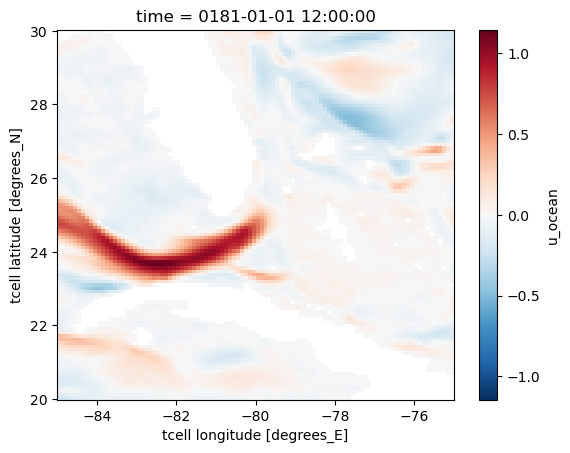

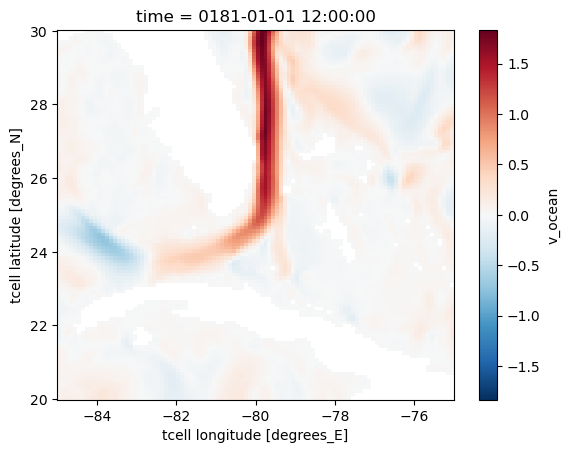

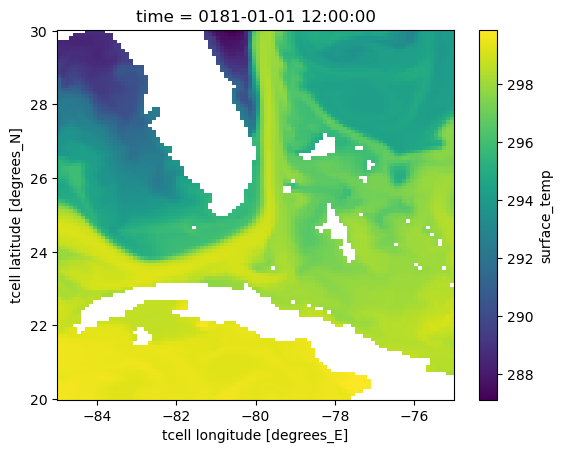

In [4]:
roi = dict(xt_ocean=slice(-85, -75), yt_ocean=slice(20,30))

plt.figure()
ds['u_ocean'].isel(time=0).sel(**roi).plot()

plt.figure()
ds['v_ocean'].isel(time=0).sel(**roi).plot()

plt.figure()
ds['surface_temp'].isel(time=0).sel(**roi).plot()

In [40]:
fs.ls('ocean-transport-group/scale-aware-air-sea/flux-output')

['ocean-transport-group/scale-aware-air-sea/flux-output/cm26.zarr',
 'ocean-transport-group/scale-aware-air-sea/flux-output/cm26_sample.zarr',
 'ocean-transport-group/scale-aware-air-sea/flux-output/cm26_split.zarr',
 'ocean-transport-group/scale-aware-air-sea/flux-output/cm26_split_full.zarr',
 'ocean-transport-group/scale-aware-air-sea/flux-output/cm26_split_full_rewrite.zarr',
 'ocean-transport-group/scale-aware-air-sea/flux-output/cm26_split_full_v2.zarr',
 'ocean-transport-group/scale-aware-air-sea/flux-output/cm26_split_full_v4.1.zarr',
 'ocean-transport-group/scale-aware-air-sea/flux-output/cm26_split_full_v4.zarr']

In [5]:
output_mapper = fs.get_mapper('ocean-transport-group/scale-aware-air-sea/results/cm26_flux_long_term_mean_v4.1.zarr')
ds_out = xr.open_dataset(output_mapper, engine='zarr', chunks={})
ds_out

<xarray.Dataset>
Dimensions:    (algo: 3, smoothing: 7, yt_ocean: 2700, xt_ocean: 3600)
Coordinates:
  * algo       (algo) <U8 'ncar' 'ecmwf' 'coare3p6'
  * smoothing  (smoothing) <U23 'smooth_full' 'smooth_tracer' ... 'smooth_all'
  * xt_ocean   (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean   (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
Data variables:
    evap       (smoothing, algo, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1, 2700, 3600), meta=np.ndarray>
    qh         (smoothing, algo, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1, 2700, 3600), meta=np.ndarray>
    ql         (smoothing, algo, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1, 2700, 3600), meta=np.ndarray>
    taux       (smoothing, algo, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1, 2700, 3600), meta=np.ndarray>
    tauy       (smoothing, algo, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1, 2700, 3600), meta=np.ndarray>

In [6]:
wet_mask = ~np.isnan(ds.surface_temp.isel(time=0))

In [7]:
# scale separation
ds_full, ds_large_scale, ds_small_scale = scale_separation(ds_out, 50, wet_mask)

In [8]:
ds = xr.merge([ds, ds_smoothed])

## Illustrate the problem
We saw this issue mostly in the fields that had smoothed temperatures, so I will target the sst fields first.

In [14]:


da = ds.surface_temp - ds.surface_temp_smoothed
da_plot = da.sel(**roi).isel(time=tt).mean('time')

## comparison to fluxes
da_flux = ds_small_scale.ql
# da_flux_plot = da_flux.sel(**roi).isel(time=tt, algo=0).mean('time')
da_flux_plot = da_flux.isel(algo=0)

# plt.figure()
# da_plot.plot(robust=True)

# plt.figure()
# da_plot.plot(robust=True)

from dask.diagnostics import ProgressBar
with ProgressBar():
    da_flux_plot = da_flux_plot.load()

[########################################] | 100% Completed | 62.99 ss


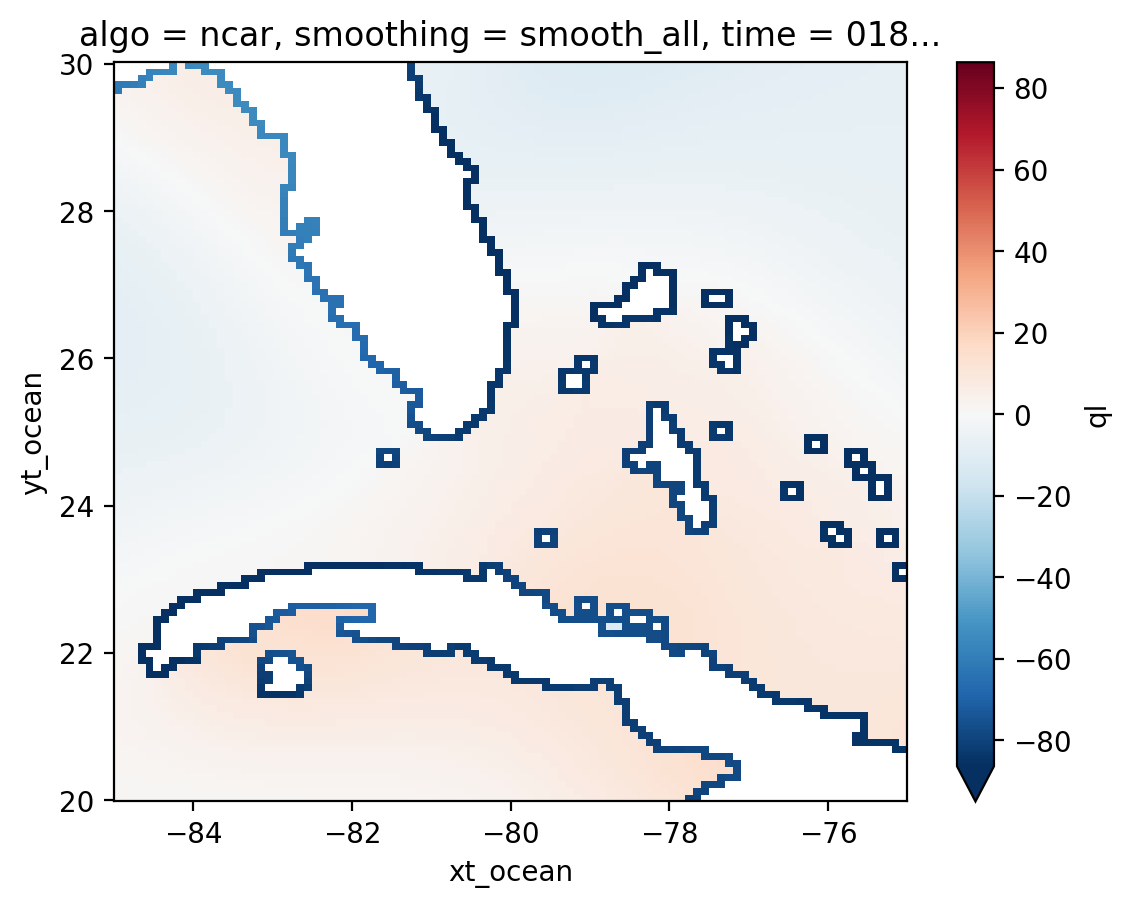

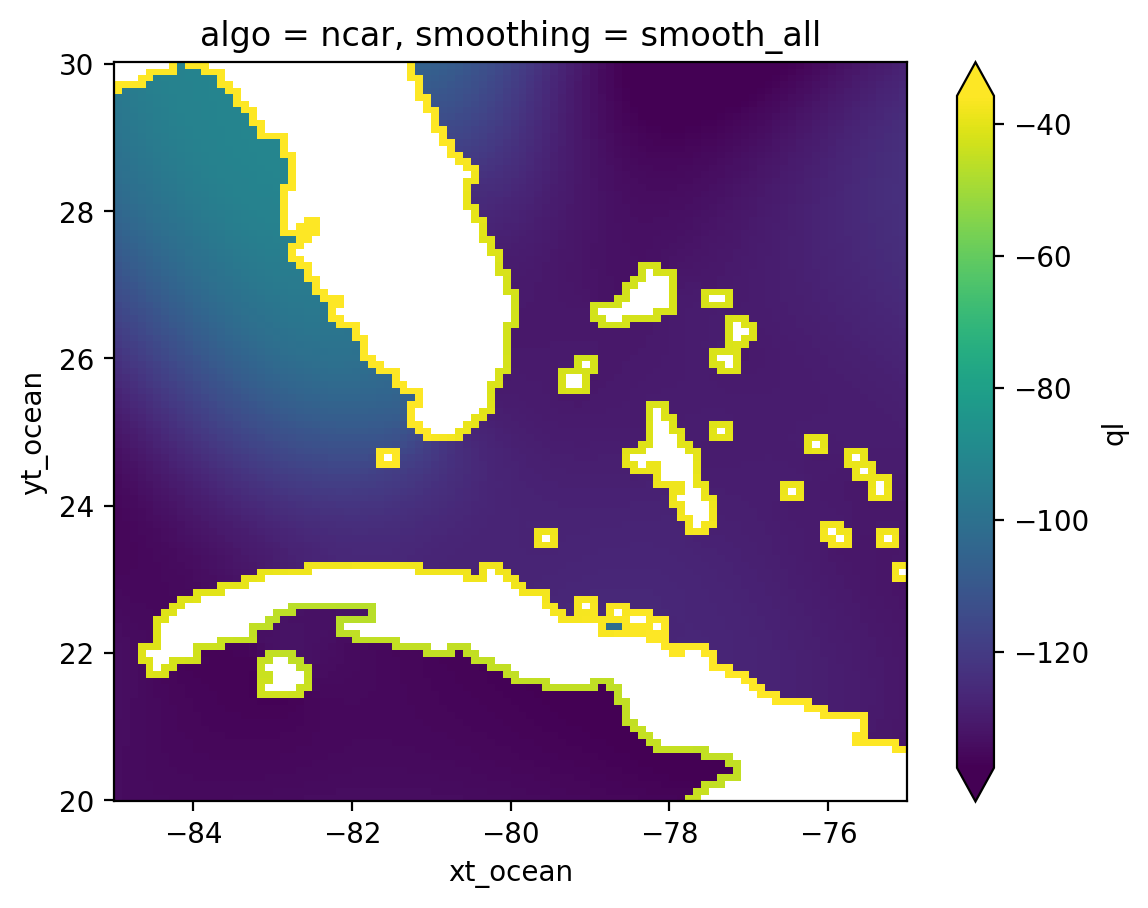

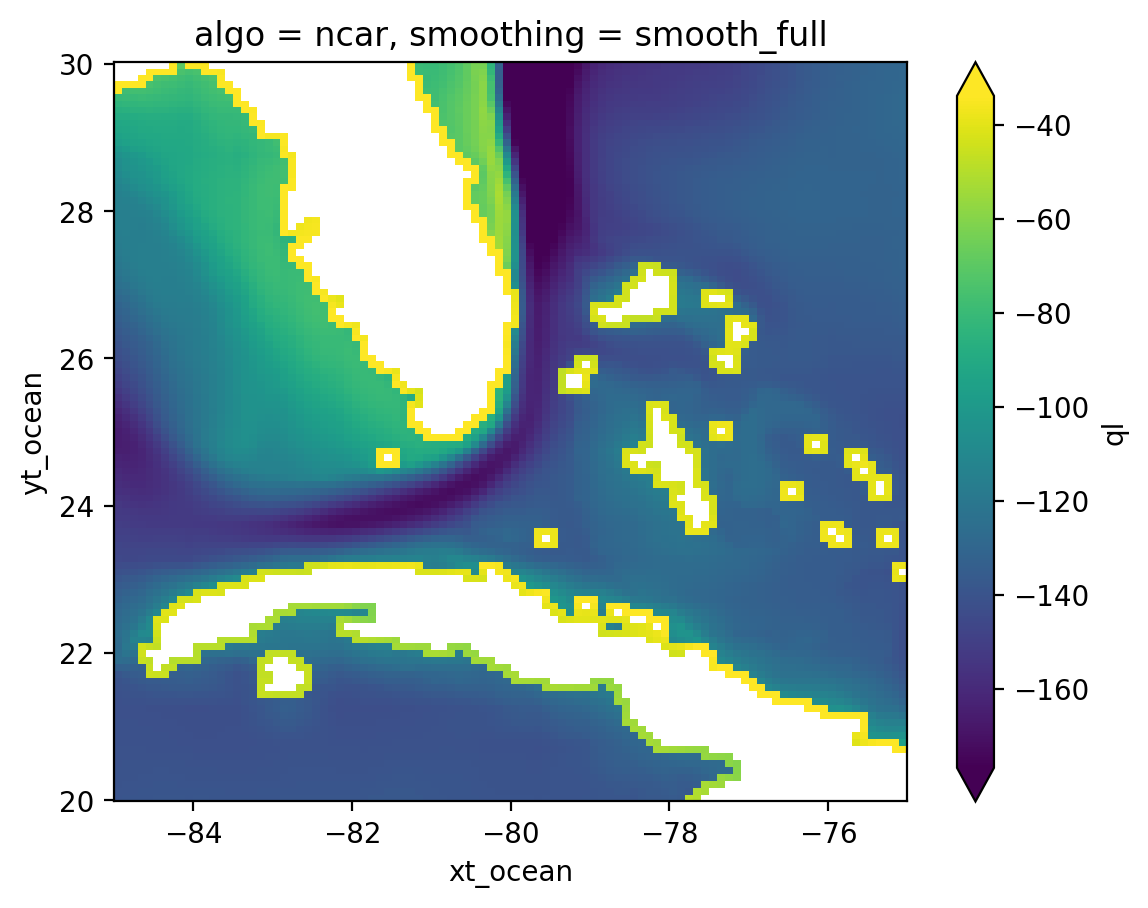

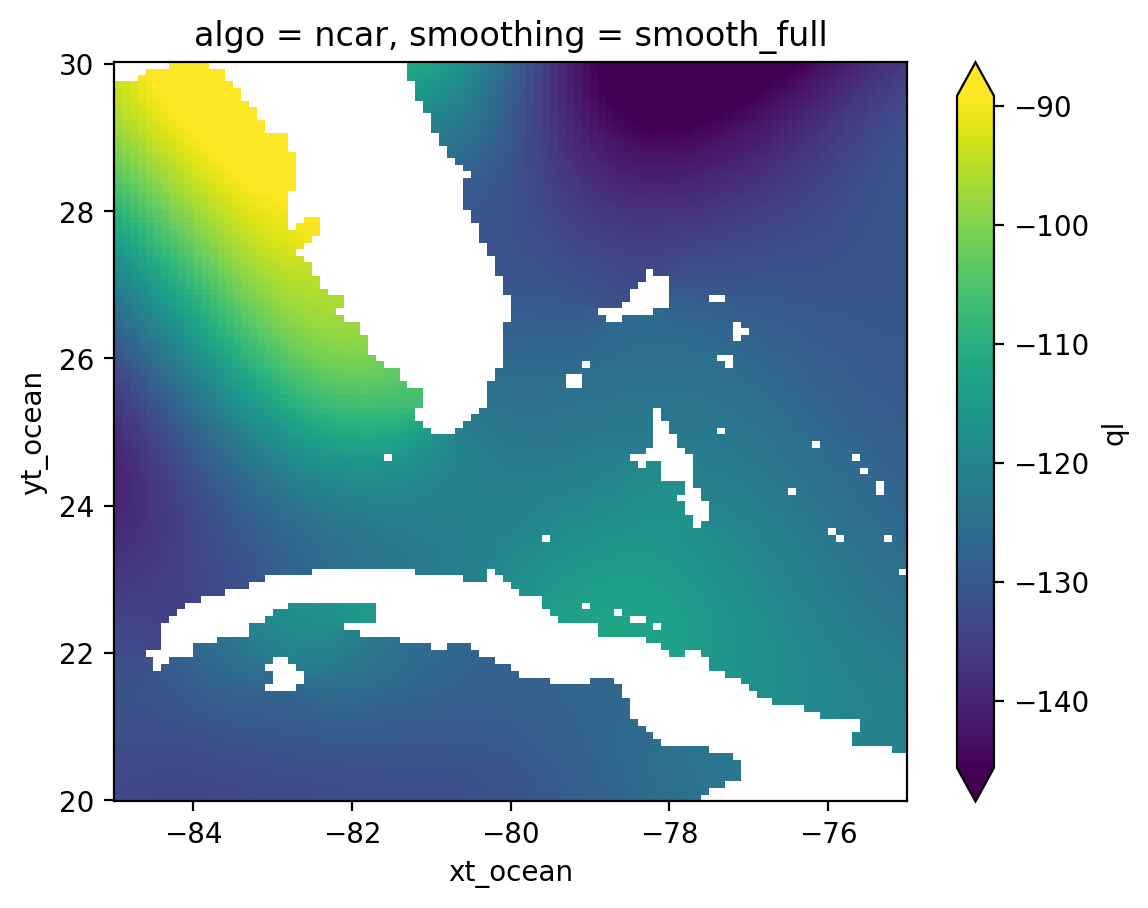

In [42]:

da_flux_plot.sel(**roi).sel(smoothing='smooth_all').plot(robust=True)

plt.figure()
ds_out['ql'].sel(**roi).isel(algo=0).sel(smoothing='smooth_all').plot(robust=True)

plt.figure()
ds_out['ql'].sel(**roi).isel(algo=0).sel(smoothing='smooth_full').plot(robust=True)

plt.figure()
smooth_inputs_dataset(ds_out, ['yt_ocean', 'xt_ocean'], 50)['ql'].sel(**roi).isel(algo=0).sel(smoothing='smooth_full').plot(robust=True)

Why is the 'smooth_full' output not showing this enlargement of the output (or the halo). The input should have the same nan structure as for the 'smooth_all'?

In [41]:
test_mapper = fs.get_mapper('ocean-transport-group/scale-aware-air-sea/flux-output/cm26_split_full_v4.1.zarr')
ds_test = xr.open_dataset(output_mapper, engine='zarr', chunks={})
ds_test

<xarray.Dataset>
Dimensions:    (algo: 3, smoothing: 7, yt_ocean: 2700, xt_ocean: 3600)
Coordinates:
  * algo       (algo) <U8 'ncar' 'ecmwf' 'coare3p6'
  * smoothing  (smoothing) <U23 'smooth_full' 'smooth_tracer' ... 'smooth_all'
  * xt_ocean   (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean   (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
Data variables:
    evap       (smoothing, algo, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1, 2700, 3600), meta=np.ndarray>
    qh         (smoothing, algo, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1, 2700, 3600), meta=np.ndarray>
    ql         (smoothing, algo, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1, 2700, 3600), meta=np.ndarray>
    taux       (smoothing, algo, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1, 2700, 3600), meta=np.ndarray>
    tauy       (smoothing, algo, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1, 2700, 3600), meta=np.ndarray>

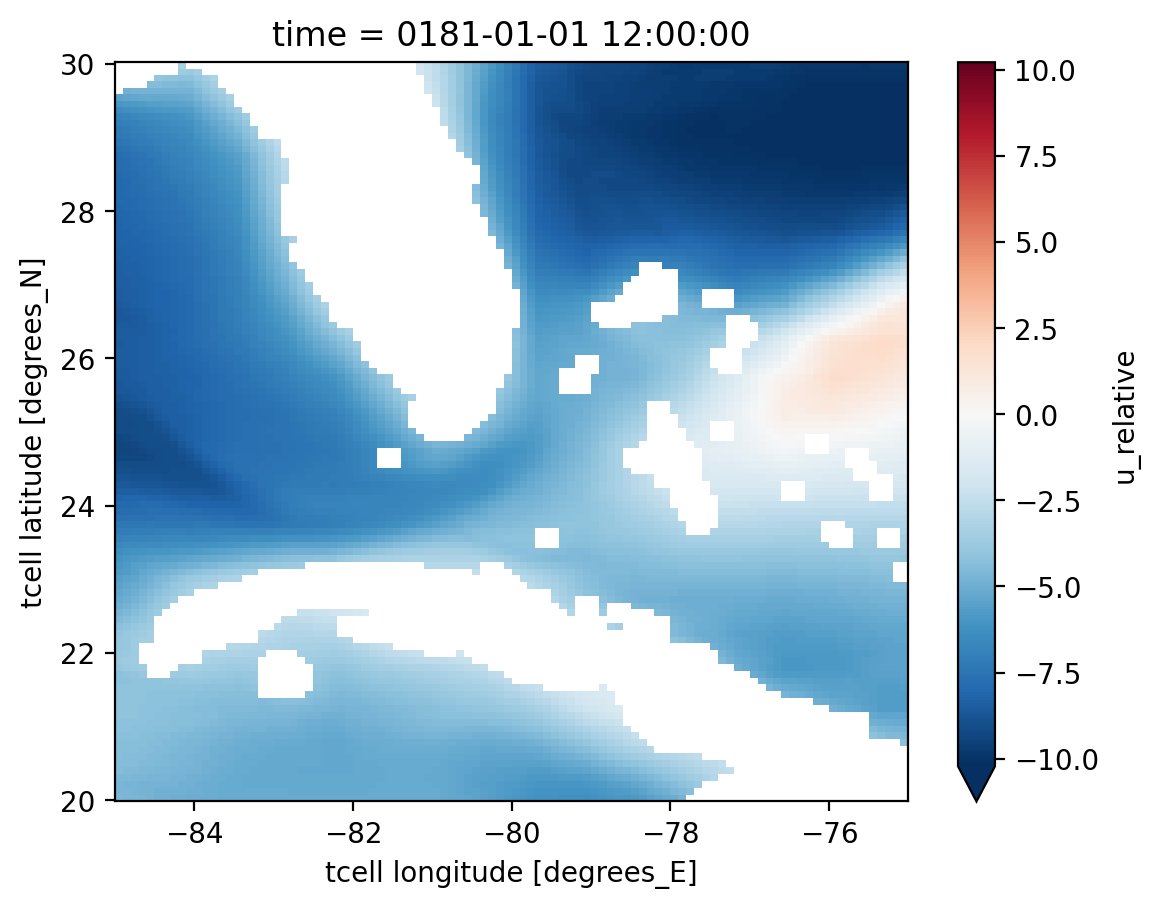

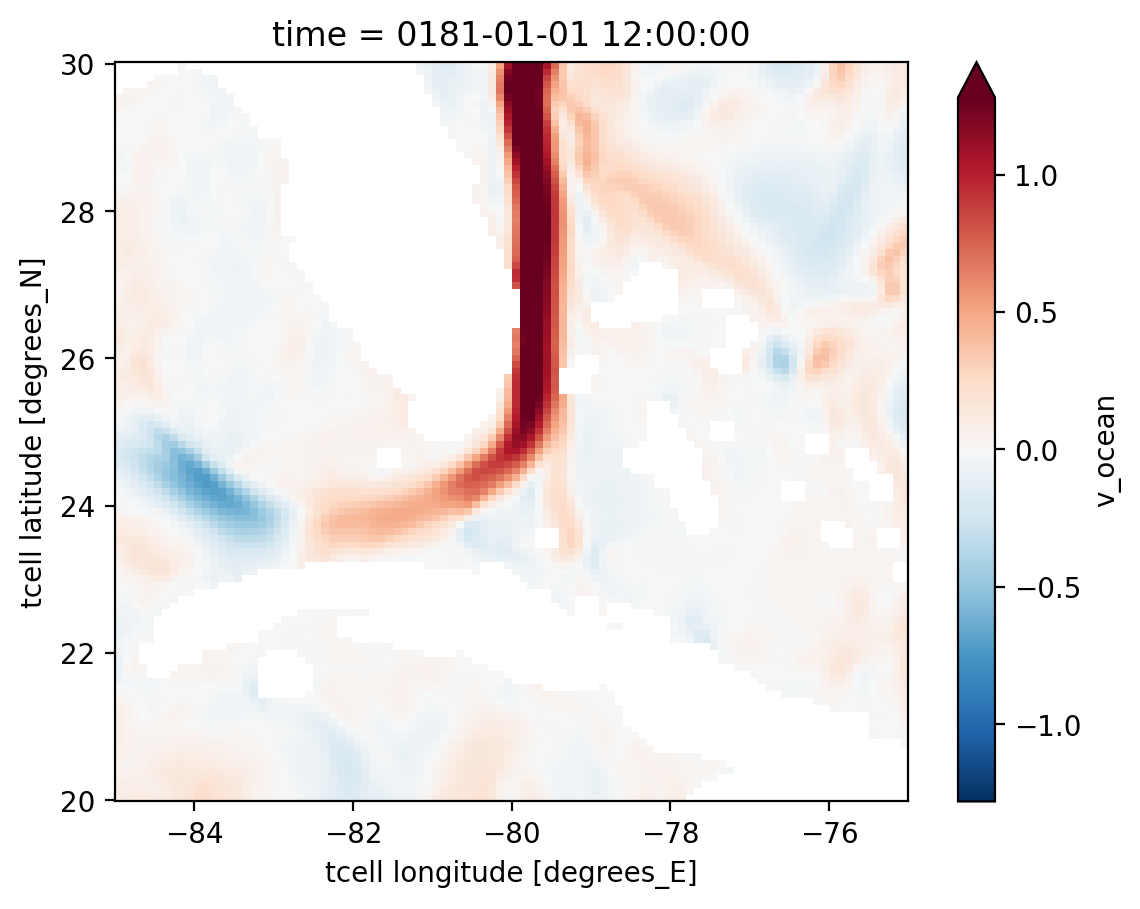

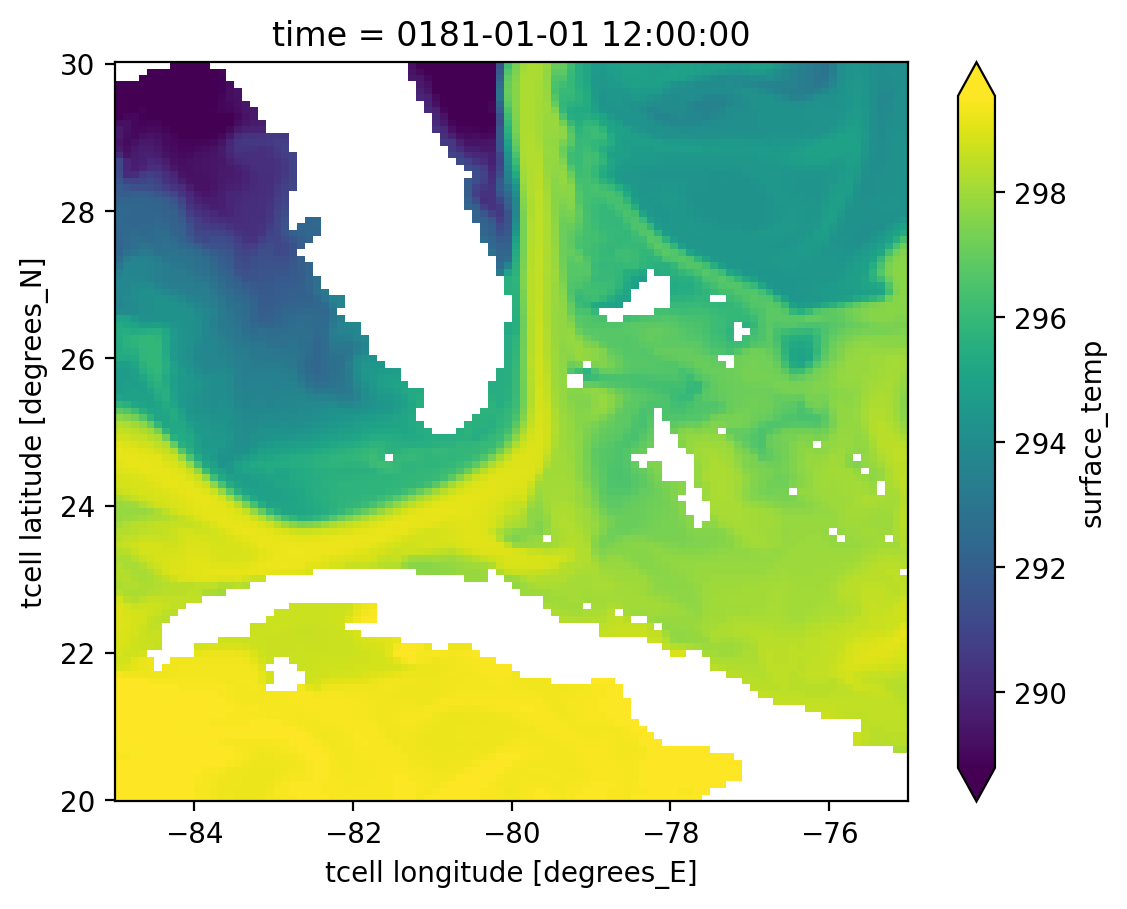

In [38]:
plt.figure()
ds['u_relative'].isel(time=0).sel(**roi).plot(robust=True)

plt.figure()
ds['v_ocean'].isel(time=0).sel(**roi).plot(robust=True)

plt.figure()
ds['surface_temp'].isel(time=0).sel(**roi).plot(robust=True)

Ok this is the issue with the 1 cell halo (which might actually affect the large scale fields!)

So there are two ways to handle this:
- Make sure that the `smooth_inputs_dataset` function aligns the mask to pixels that are nan in 'any' of the dataarrays.
- Do something similar in the aerobulk-python masking...This might affect performance, but might be better to prevent users from computing complete nonsense?

## Observations

- There is an even smaller 'halo' that seems to be a single grid box wide. Does gcm_filters erode/shrink the nans?


## Possible issues

- Gcm-filters is doing something wrong
- 


Extra: 'Bleeding' over thin continental margins (can we improve this in gcm-filters?)